# Brook Stickleback GATK summary analyses

Here I will evaluate several of the main steps in the GATK analysis pipeline for the Brook stickleback dataset from Jon Mee. 

The dataset comes from 2 lakes, Muir and Shunda, both in Alberta, with 98 and 97 samples respectively. I am running them through the standard germline SNP calling pipeline from GATK, aligning to the ninespine genome.


### First lets have a look at the raw data.

In [31]:
RG_dict = {}

with open("/home/djeffrie/Dropbox/Sexy_sticklebacks/Data/Brook_Mee/SHU_datatable.csv", 'r') as read_data:
    for line in read_data:
        if not line.startswith(","):            
            line = line.strip().strip(",")
            name = line.split(",")[0]
            model = line.split(",")[18]
            lane = line.split(",")[17]
            seq_unit = "%s_%s" % (model, lane)
            RG_dict[name] = seq_unit
            
with open("/home/djeffrie/Dropbox/Sexy_sticklebacks/Data/Brook_Mee/MUI_datatable.csv", 'r') as read_data:
    for line in read_data:
        if not line.startswith(","):            
            line = line.strip().strip(",")
            name = line.split(",")[0]
            model = line.split(",")[18]
            lane = line.split(",")[17]
            seq_unit = "%s_%s" % (model, lane)
            RG_dict[name] = seq_unit

In [32]:
RG_dict

{'FSH_003': 'HI_3',
 'FSH_004': 'HI_3',
 'FSH_005': 'HI_3',
 'FSH_009': 'HI_3',
 'FSH_010': 'HI_3',
 'FSH_011': 'HI_3',
 'FSH_013': 'HI_3',
 'FSH_014': 'HI_3',
 'FSH_015': 'HI_3',
 'FSH_016': 'HI_3',
 'FSH_018': 'HI_3',
 'FSH_021': 'HI_3',
 'FSH_023': 'HI_3',
 'FSH_024': 'HI_3',
 'FSH_025': 'NS_4',
 'FSH_027': 'HI_3',
 'FSH_029': 'HI_3',
 'FSH_032': 'HI_3',
 'FSH_033': 'HI_3',
 'FSH_036': 'HI_3',
 'FSH_038': 'HI_3',
 'FSH_039': 'HI_2',
 'FSH_041': 'HI_2',
 'FSH_042': 'HI_2',
 'FSH_043': 'HI_2',
 'FSH_044': 'HI_2',
 'FSH_056': 'HI_2',
 'FSH_059': 'NS_4',
 'FSH_065': 'HI_2',
 'FSH_066': 'HI_2',
 'FSH_067': 'HI_2',
 'FSH_071': 'HI_2',
 'FSH_074': 'HI_2',
 'FSH_076': 'HI_4',
 'FSH_077': 'HI_4',
 'FSH_079': 'HI_4',
 'FSH_080': 'HI_4',
 'FSH_081': 'HI_4',
 'FSH_083': 'HI_4',
 'FSH_091': 'HI_4',
 'FSH_097': 'HI_4',
 'FSH_099': 'HI_4',
 'FSH_102': 'NS_4',
 'FSH_105': 'NS_4',
 'MUI-19-007': 'NS_4',
 'MUI-19-021': 'NS_4',
 'MUI-19-022': 'NS_4',
 'MUI-19-023': 'NS_4',
 'MUI-19-024': 'NS_4',
 'MUI

In [33]:
set(RG_dict.values())

{'HI_1', 'HI_2', 'HI_3', 'HI_4', 'NS_4', 'model_lane'}

In [36]:
col_dict= {}

col_dict['HI_1'] = "navy"
col_dict['HI_2'] = "blue"
col_dict['HI_3'] = "darkviolet"
col_dict['HI_4'] = "fuchsia"
col_dict['NS_4'] = "crimson"



In [38]:
help(plt.legend)

Help on function legend in module matplotlib.pyplot:

legend(*args, **kwargs)
    Place a legend on the axes.
    
    Call signatures::
    
        legend()
        legend(labels)
        legend(handles, labels)
    
    The call signatures correspond to three different ways how to use
    this method.
    
    **1. Automatic detection of elements to be shown in the legend**
    
    The elements to be added to the legend are automatically determined,
    when you do not pass in any extra arguments.
    
    In this case, the labels are taken from the artist. You can specify
    them either at artist creation or by calling the
    :meth:`~.Artist.set_label` method on the artist::
    
        line, = ax.plot([1, 2, 3], label='Inline label')
        ax.legend()
    
    or::
    
        line, = ax.plot([1, 2, 3])
        line.set_label('Label via method')
        ax.legend()
    
    Specific lines can be excluded from the automatic legend element
    selection by defining a label st

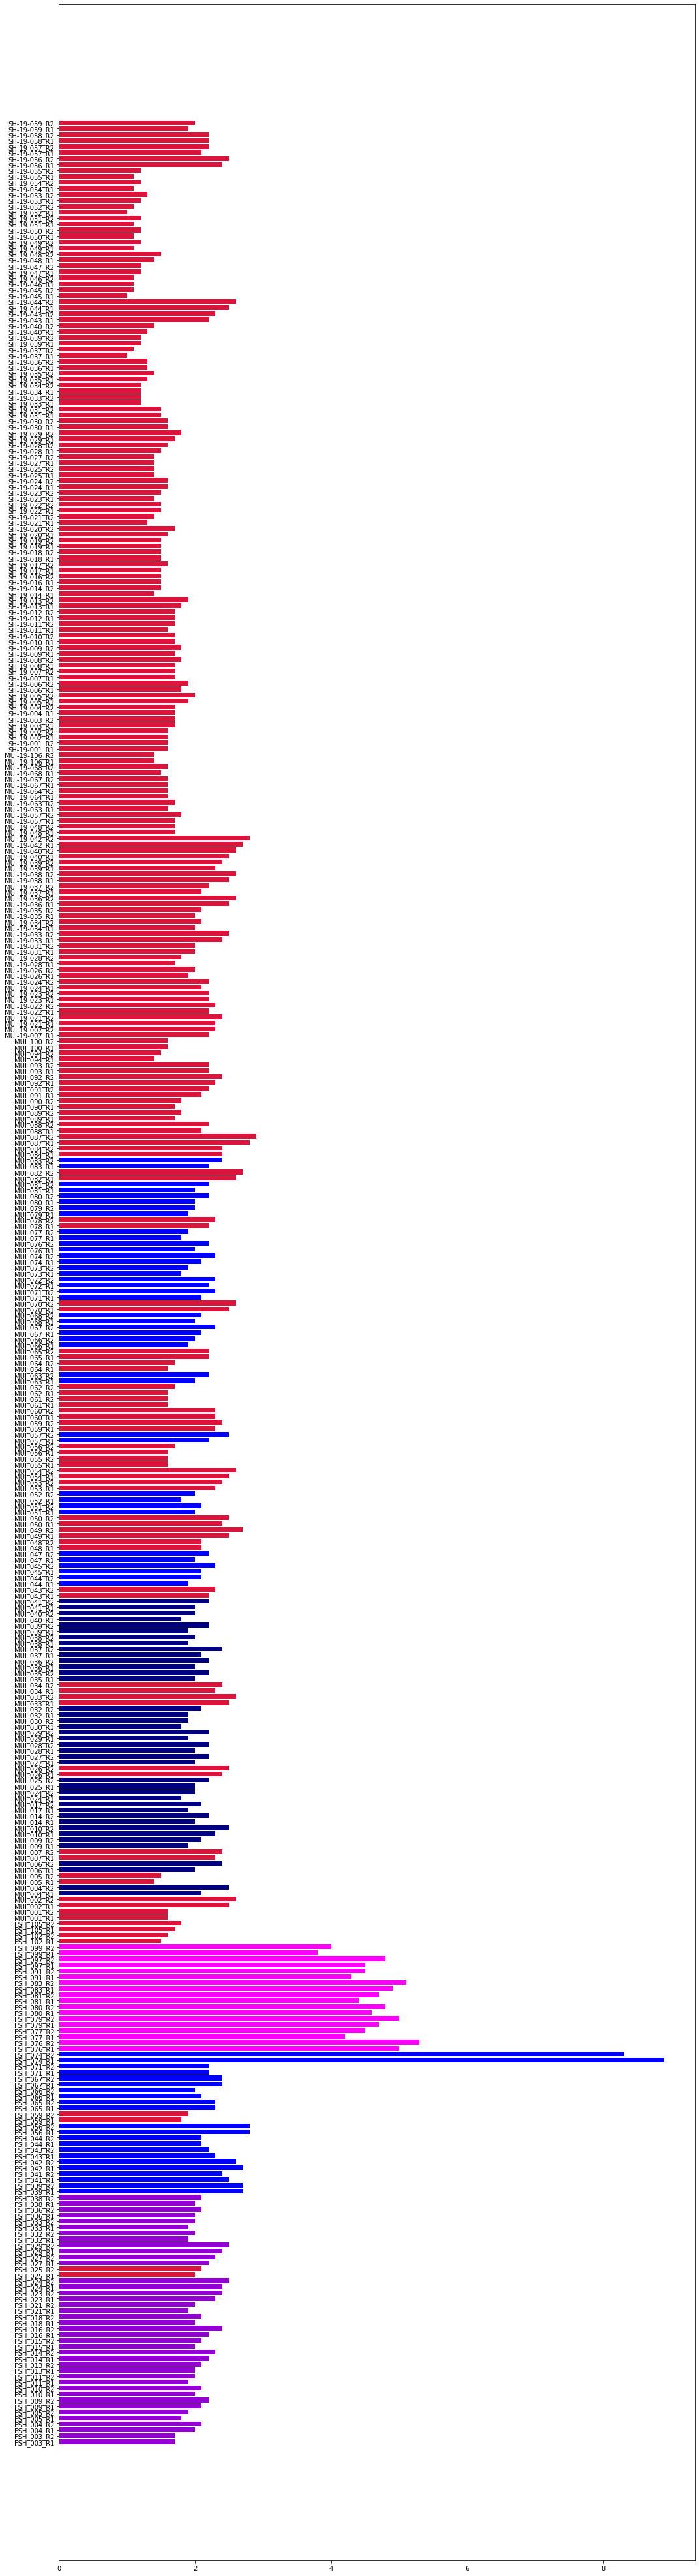

In [37]:
from matplotlib import pyplot as plt

bars = []
names = []
cols = []

with open("/home/djeffrie/Dropbox/Sexy_sticklebacks/Data/Brook_Mee/File_sizes.txt", 'r') as data:
    for line in data:
        bars.append(float(line.split()[0][:3]))
        names.append(line.split()[1])
        cols.append(col_dict[RG_dict[line.split()[1].rpartition("_")[0]]])
        
plt.figure(figsize = (15, 55))
plt.barh(list(range(1, len(bars)+1)), 
         bars, 
         tick_label = names, 
         color = cols)
plt.tight_layout()
plt.show()
        

Ok data looks pretty consistent, there are a fewsamples with huge coverage for some reason. Which seem to have been sequenced on a single lane together, I guess there just weren't many samples to fill the lane/ FSH_074 is very high, not sure why though. The rest look great, and library / lane doesn't seem to affect things too much. The amount of Nova seq (red) output is insane! 

## Read trimming.

I then trimmed reads for illumina adapters. Using trimomatic. The results are below. 

In [45]:
## First I need to get the array job number for each sample (as this is how the stats are collated in the summary data file I made)

sample_job_names = {}

with open("/home/djeffrie/Dropbox/Sexy_sticklebacks/Data/Brook_Mee/GATK_summary_stats/All_sample_names.txt", 'r') as names_file:
    JN = 1
    for line in names_file:
        sample_job_names[line.split()[0]] = JN
        JN += 1

In [44]:
sample_job_names

{'FSH_003': 1,
 'FSH_004': 2,
 'FSH_005': 3,
 'FSH_009': 4,
 'FSH_010': 5,
 'FSH_011': 6,
 'FSH_013': 7,
 'FSH_014': 8,
 'FSH_015': 9,
 'FSH_016': 10,
 'FSH_018': 11,
 'FSH_021': 12,
 'FSH_023': 13,
 'FSH_024': 14,
 'FSH_025': 15,
 'FSH_027': 16,
 'FSH_029': 17,
 'FSH_032': 18,
 'FSH_033': 19,
 'FSH_036': 20,
 'FSH_038': 21,
 'FSH_039': 22,
 'FSH_041': 23,
 'FSH_042': 24,
 'FSH_043': 25,
 'FSH_044': 26,
 'FSH_056': 27,
 'FSH_059': 28,
 'FSH_065': 29,
 'FSH_066': 30,
 'FSH_067': 31,
 'FSH_071': 32,
 'FSH_074': 33,
 'FSH_076': 34,
 'FSH_077': 35,
 'FSH_079': 36,
 'FSH_080': 37,
 'FSH_081': 38,
 'FSH_083': 39,
 'FSH_091': 40,
 'FSH_097': 41,
 'FSH_099': 42,
 'FSH_102': 43,
 'FSH_105': 44,
 'MUI-19-007': 119,
 'MUI-19-021': 120,
 'MUI-19-022': 121,
 'MUI-19-023': 122,
 'MUI-19-024': 123,
 'MUI-19-026': 124,
 'MUI-19-028': 125,
 'MUI-19-031': 126,
 'MUI-19-033': 127,
 'MUI-19-034': 128,
 'MUI-19-035': 129,
 'MUI-19-036': 130,
 'MUI-19-037': 131,
 'MUI-19-038': 132,
 'MUI-19-039': 133,
 'MUI

In [49]:
with open("/home/djeffrie/Dropbox/Sexy_sticklebacks/Data/Brook_Mee/GATK_summary_stats/Summary_stats.txt", 'r') as summary_stats:
    
    for line in summary_stats:
        if not line.split()[0] == "Job_Name":
            print(line.strip())
            JN=int(line.split()[0].split("-")[1])
            


TRIM_38685182-10	23285087	21188120	90.99	1767046	7.59	156196	0.67	173725	0.75
TRIM_38685182-1	17683677	16600469	93.87	858038	4.85	122064	0.69	103106	0.58
TRIM_38685182-2	21146021	19525417	92.34	1309065	6.19	158110	0.75	153429	0.73
TRIM_38685182-3	19099928	17824144	93.32	1008061	5.28	133255	0.70	134468	0.70
TRIM_38685182-4	22489488	21045079	93.58	1133365	5.04	171662	0.76	139382	0.62
TRIM_38685182-5	20678263	19095551	92.35	1253251	6.06	142822	0.69	186639	0.90
TRIM_38685182-6	19883856	18551080	93.30	1056578	5.31	136925	0.69	139273	0.70
TRIM_38685182-7	21462725	19828155	92.38	1301751	6.07	153106	0.71	179713	0.84
TRIM_38685182-8	23341746	21768859	93.26	1272924	5.45	158362	0.68	141601	0.61
TRIM_38685182-9	21299577	19483130	91.47	1507215	7.08	150198	0.71	159034	0.75
TRIM_38699113-100	25168441	23344854	92.75	1071640	4.26	111085	0.44	640862	2.55
TRIM_38699113-101	23973424	22413398	93.49	1082164	4.51	101061	0.42	376801	1.57
TRIM_38699113-102	20692317	19370776	93.61	1010755	4.88	89156	0.43	221630